<a href="https://colab.research.google.com/github/yoavdana/ex1_DL/blob/main/ex1_copy2232.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
!git clone https://github.com/yoavdana/ex1_DL.git

Cloning into 'ex1_DL'...
remote: Enumerating objects: 109, done.
remote: Counting objects: 100% (109/109), done.
remote: Compressing objects: 100% (93/93), done.
remote: Total 109 (delta 38), reused 48 (delta 9), pack-reused 0
Receiving objects: 100% (109/109), 59.26 MiB | 30.10 MiB/s, done.
Resolving deltas: 100% (38/38), done.


In [4]:
import torch 
import numpy as np
import scipy.stats as si
import torch
import torch.nn as nn
import numpy as np
import torch.nn.functional as F
from sklearn.metrics import f1_score
import torch.optim as optim
import torch.utils.data as data
from time import time
import matplotlib.pyplot as plt
import torchvision.transforms as transforms
from tqdm import tqdm
import pandas as pd

# Loading Data

Data Proccesing

In [113]:
SEQ_LENGTH = 20
BATCH_SIZE = 64
MAPPING = {'A': 0, 'R': 1, 'N': 2, 'D': 3, 'C': 4, 'E': 5, 'Q': 6, 'G': 7, 'H': 8, 'I': 9, 'L': 10, 'K': 11,
              'M': 12, 'F': 13, 'P': 14, 'S': 15, 'T': 16, 'W': 17, 'Y': 18, 'V': 19}


def data_to_input(sequence, pos_or_neg):
    map=np.zeros((9, 20))
    for i, seq in enumerate(sequence):
        map[i,MAPPING[seq]]+=1
    map = map.flatten()
    if pos_or_neg==None:
        return map
    return np.concatenate([map, np.array([pos_or_neg])])

def read_data(filename, pos_or_neg):
    file = open(filename, 'r')
    lines=file.readlines()
    data = np.zeros((len(lines), 181))
    if pos_or_neg == None:
        data = np.zeros((len(lines), 180))
    for i, line in enumerate(lines):
        input = data_to_input(line.replace('\n', ''), pos_or_neg)
        data[i] = input
    return data

# def bootstrap(DATA,size,NUMBER_OF_BATCHS):

#     new_DATA=np.zeros((size,181))
#     N=DATA.shape[0]
#     batch_size=N//NUMBER_OF_BATCHS
#     for i in range(NUMBER_OF_BATCHS):

#         random = np.random.randint(batch_size*i,batch_size*(i+1), size=size//NUMBER_OF_BATCHS)
#         new_DATA[((size//NUMBER_OF_BATCHS)*i):(size//NUMBER_OF_BATCHS)*(i+1), :] = DATA[random, :]
#     return new_DATA


def bootstrap(data,size,NUMBER_OF_BATCHS):

    N=data.shape[0]
    batch_size=N//NUMBER_OF_BATCHS
    for i in range(NUMBER_OF_BATCHS):
        random = np.random.randint(batch_size*i,batch_size*(i+1), size=size//NUMBER_OF_BATCHS)
        data =np.vstack([DATA,DATA[random, :]])
    return data


def data_pre_pros(filename_pos,filename_neg):

    neg_data=read_data(filename_neg, 0)
    pos_data=read_data(filename_pos, 1)
    
    neg_data_train = neg_data[:int(len(neg_data)*0.9)]
    neg_data_test = neg_data[int(len(neg_data)*0.9):]
    pos_data_train = pos_data[:int(len(pos_data)*0.9)]
    pos_data_test = pos_data[int(len(pos_data)*0.9):]
    #pos_data_train = bootstrap(pos_data_train, int(BOOTSTRAP_SIZE*0.9), int(NUMBER_OF_BATCHS*0.9))
    #pos_data_test = bootstrap(pos_data_test, int(BOOTSTRAP_SIZE*0.1), int(NUMBER_OF_BATCHS*0.1))

    final_data_train = np.concatenate([neg_data_train, pos_data_train])
    final_data_test = np.concatenate([neg_data_test, pos_data_test])
    return final_data_train, final_data_test


def shuffle_data(data_Xy):
    np.random.shuffle(data_Xy)
    return data_Xy[:,:180],data_Xy[:,-1]


def spike_seq(filename):
    with open(filename) as f:
        lines = f.readlines()[0]
        print(lines)
        predeict=list()

        if len(lines) == 9:
            map = np.zeros((9, 20))
            for i, seq in enumerate(lines):
                map[i, MAPPING[seq]] += 1
            map = map.flatten()
            predeict.append(map)
        else:
            for i in range(len(lines)-9):
                map = np.zeros((9, 20))
                for i, seq in enumerate(lines[i:i+9]):
                    map[i, MAPPING[seq]] += 1
                map = map.flatten()
                predeict.append(map)
        
        return np.array(predeict)


In [13]:
filename_pos='/content/ex1_DL/resorces/pos_A0201.txt'
filename_neg='/content/ex1_DL/resorces/neg_A0201.txt'

train_set, test_set=data_pre_pros(filename_pos,filename_neg)
train_x, train_y = train_set[:,:180], train_set[:,-1]
test_x, test_y = test_set[:,:180], test_set[:,-1]

train_target = torch.from_numpy(train_y.astype(np.int64))
train = torch.from_numpy(train_x.astype(np.float32)) 
train_tensor = torch.utils.data.TensorDataset(train, train_target) 
train_dataloader = torch.utils.data.DataLoader(dataset = train_tensor, batch_size = BATCH_SIZE, shuffle = True)

test_target = torch.from_numpy(test_y.astype(np.int64))
test = torch.from_numpy(test_x.astype(np.float32)) 
test_tensor = torch.utils.data.TensorDataset(test, test_target) 
test_dataloader = torch.utils.data.DataLoader(dataset = test_tensor, batch_size = BATCH_SIZE, shuffle = True)


# Evaluation functions

In [94]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)


# def calculate_accuracy(y_pred, y):
#     top_pred = y_pred.argmax(1, keepdim = True)
#     correct = top_pred.eq(y.view_as(top_pred)).sum()
#     acc = correct.float() / y.shape[0]
#     return acc


# def calculate_accuracy(y_pred, y):
#     top_pred = y_pred.argmax(1, keepdim = True)
#     f1 = f1_score(y_pred,y)
#     return f1
    

def calculate_accuracy(y_true, y_pred, is_training=False):
    if y_pred.ndim == 2:
        y_pred = y_pred.argmax(dim=1)
       
   
    tp = (y_true * y_pred).sum().to(torch.float32)
    tn = ((1 - y_true) * (1 - y_pred)).sum().to(torch.float32)
    fp = ((1 - y_true) * y_pred).sum().to(torch.float32)
    fn = (y_true * (1 - y_pred)).sum().to(torch.float32)
   
    epsilon = 1e-7
   
    precision = tp / (tp + fp + epsilon)
    recall = tp / (tp + fn + epsilon)
    accuracy = (tp + tn) / (tp + tn + fp + fn + epsilon)
   
    f1 = 2* (precision*recall) / (precision + recall + epsilon)
    f1.requires_grad = is_training
    return accuracy

## Network architecture

In [368]:
# Network parameters
INPUT=180
INPUT_1=15
INPUT_2=10
INPUT_3=4
INPUT_4=32
INPUT_5=16
INPUT_6=8
INPUT_7=4
OUTPUT=2
P_DROPOUT=0.1
P_DROPOUT_2=0.15

LEARNNING_RATE=0.000075

BOOTSTRAP_SIZE=15000
NUMBER_OF_BATCHS=150

EPOCHS = 40

In [369]:
class Network(nn.Module):
    def __init__(self):
        super(Network, self).__init__()

        self.input_fc = nn.Linear(INPUT, INPUT_1)
        
        self.hidden_1_fc = nn.Linear(INPUT_1, INPUT_2)
        
        self.hidden_2_fc = nn.Linear(INPUT_2, INPUT_3)

        self.output_fc = nn.Linear(INPUT_3, OUTPUT)

        self.dropout = nn.Dropout(P_DROPOUT)

        
        self.batch_norm_1 = nn.BatchNorm1d(INPUT_1)
        self.batch_norm_2 = nn.BatchNorm1d(INPUT_2)



    def forward(self, x):
   

        h_1 = F.relu(self.batch_norm_1(self.input_fc(x)))

        h_1=self.dropout(h_1)

        h_2 = F.relu(self.batch_norm_2(self.hidden_1_fc(h_1)))

        # h_2=self.dropout(h_2)

        h_3 = F.relu(self.hidden_2_fc(h_2))

        #h_3=self.dropout2(h_3)

        y_pred = self.output_fc(h_3)

        return y_pred, h_3



device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = Network().to(device)
optimizer=optim.Adam(model.parameters(), lr=LEARNNING_RATE)
weights = [train_set.shape[0]/(2*2.4*np.sum(train_set[:, -1])), 2.4*np.sum(train_set[:, -1])/(2*(train_set.shape[0]-np.sum(train_set[:, -1])))] #as class distribution
weights.reverse()
class_weights = torch.FloatTensor(weights).to(device)
criterion = nn.CrossEntropyLoss(weight=class_weights)

# Train Loop

In [124]:
start_time=time()

for epoch in range(20):
    running_loss=0.0
    pbar=tqdm(iterable=train_dataloader)
    for i,batch in enumerate(pbar):
      batch=[item.to(device) for  item in batch]
      sequences, labels=batch
      # zero the parameter gradients
      optimizer.zero_grad()
      # forward 
      outputs, _ = model(sequences)
      #calculate the loss between the target and the actuals
      loss= criterion(input=outputs, target=labels)
      #Gradient calculation uisng backward pass
      loss.backward()
      # update the weights
      optimizer.step()
      running_loss+=loss.item()
      pbar.set_postfix(loss=running_loss/(i+1))
    pbar.close()
    print('epoch %d -Loss %.3f' % (epoch +1,running_loss/(len(train_tensor)/BATCH_SIZE)))      
    running_loss = 0.0

print("Time for training using PyTorch %f" %(time()-start_time))

100%|██████████| 387/387 [00:03<00:00, 122.14it/s, loss=0.289]


epoch 1 -Loss 0.289


100%|██████████| 387/387 [00:03<00:00, 121.26it/s, loss=0.131]


epoch 2 -Loss 0.131


100%|██████████| 387/387 [00:03<00:00, 122.79it/s, loss=0.12]


epoch 3 -Loss 0.120


100%|██████████| 387/387 [00:03<00:00, 121.10it/s, loss=0.116]


epoch 4 -Loss 0.116


100%|██████████| 387/387 [00:03<00:00, 121.53it/s, loss=0.114]


epoch 5 -Loss 0.114


100%|██████████| 387/387 [00:03<00:00, 122.54it/s, loss=0.116]


epoch 6 -Loss 0.116


100%|██████████| 387/387 [00:03<00:00, 122.28it/s, loss=0.11]


epoch 7 -Loss 0.110


100%|██████████| 387/387 [00:03<00:00, 120.90it/s, loss=0.114]


epoch 8 -Loss 0.114


100%|██████████| 387/387 [00:03<00:00, 120.51it/s, loss=0.109]


epoch 9 -Loss 0.109


100%|██████████| 387/387 [00:03<00:00, 118.58it/s, loss=0.109]


epoch 10 -Loss 0.110


100%|██████████| 387/387 [00:03<00:00, 117.21it/s, loss=0.111]


epoch 11 -Loss 0.111


100%|██████████| 387/387 [00:03<00:00, 119.94it/s, loss=0.11]


epoch 12 -Loss 0.110


100%|██████████| 387/387 [00:03<00:00, 120.39it/s, loss=0.107]


epoch 13 -Loss 0.107


100%|██████████| 387/387 [00:03<00:00, 120.04it/s, loss=0.109]


epoch 14 -Loss 0.109


100%|██████████| 387/387 [00:03<00:00, 120.90it/s, loss=0.108]


epoch 15 -Loss 0.108


100%|██████████| 387/387 [00:03<00:00, 119.06it/s, loss=0.106]


epoch 16 -Loss 0.106


100%|██████████| 387/387 [00:03<00:00, 118.97it/s, loss=0.106]


epoch 17 -Loss 0.106


100%|██████████| 387/387 [00:03<00:00, 117.70it/s, loss=0.108]


epoch 18 -Loss 0.108


100%|██████████| 387/387 [00:03<00:00, 118.98it/s, loss=0.105]


epoch 19 -Loss 0.105


100%|██████████| 387/387 [00:03<00:00, 120.47it/s, loss=0.106]

epoch 20 -Loss 0.106
Time for training using PyTorch 64.577247


In [364]:
def train_model(model, train_dataloader, optimizer, criterion, device):
    epoch_loss = 0
    epoch_acc = 0
    model.train()

    for i,batch in enumerate(train_dataloader):
        batch=[item.to(device) for item in batch]
        sequences, labels=batch
        # zero the parameter gradients
        optimizer.zero_grad()
      
        # forward 
        outputs, _ = model(sequences)
        #calculate the loss between the target and the actuals
        loss= criterion(input=outputs, target=labels)
        #Gradient calculation uisng backward pass
        acc=calculate_accuracy(labels, outputs)
        loss.backward()
        # update the weights
        optimizer.step()
        epoch_loss += loss.item()
        epoch_acc += acc.item()

    return epoch_loss / len(train_dataloader), epoch_acc / len(train_dataloader)


def evaluate(model, test_dataloader, criterion, device):
    epoch_loss = 0
    epoch_acc = 0
    model.eval()

    for i,batch in enumerate(test_dataloader):
        batch=[item.to(device) for item in batch]
        sequences, labels=batch
        # zero the parameter gradients
        optimizer.zero_grad()
      
        # forward 
        outputs, _ = model(sequences)
        #calculate the loss between the target and the actuals
        loss= criterion(input=outputs, target=labels)
        #Gradient calculation uisng backward pass
        acc=calculate_accuracy(labels, outputs)
        epoch_loss += loss.item()
        epoch_acc += acc.item()

    return epoch_loss / len(test_dataloader), epoch_acc / len(test_dataloader)


The model has 2,979 trainable parameters
weights: [0.14650213229289538, 1.9147931376192246]
Epoch: 01
	Train Loss: 0.674 | Train Acc: 20.58%
Epoch: 01
	Test Loss: 0.655 | Test Acc: 20.98%
Epoch: 02
	Train Loss: 0.633 | Train Acc: 26.66%
Epoch: 02
	Test Loss: 0.607 | Test Acc: 32.18%
Epoch: 03
	Train Loss: 0.578 | Train Acc: 39.17%
Epoch: 03
	Test Loss: 0.541 | Test Acc: 45.96%
Epoch: 04
	Train Loss: 0.510 | Train Acc: 52.92%
Epoch: 04
	Test Loss: 0.467 | Test Acc: 61.93%
Epoch: 05
	Train Loss: 0.448 | Train Acc: 63.96%
Epoch: 05
	Test Loss: 0.406 | Test Acc: 68.43%
Epoch: 06
	Train Loss: 0.392 | Train Acc: 71.26%
Epoch: 06
	Test Loss: 0.361 | Test Acc: 74.04%
Epoch: 07
	Train Loss: 0.348 | Train Acc: 75.23%
Epoch: 07
	Test Loss: 0.320 | Test Acc: 77.74%
Epoch: 08
	Train Loss: 0.321 | Train Acc: 77.85%
Epoch: 08
	Test Loss: 0.297 | Test Acc: 79.28%
Epoch: 09
	Train Loss: 0.301 | Train Acc: 79.76%
Epoch: 09
	Test Loss: 0.279 | Test Acc: 81.02%
Epoch: 10
	Train Loss: 0.288 | Train Acc: 80

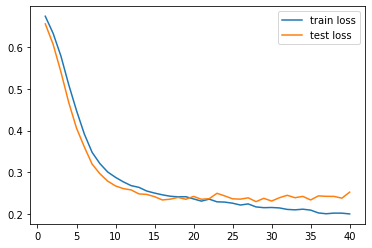

In [370]:
print(f'The model has {count_parameters(model):,} trainable parameters')
print(f'weights: {weights}')
train_per_ep=[]
test_per_ep=[]
test_acc = 0
for epoch in range(EPOCHS):
    train_loss, train_acc = train_model(model, train_dataloader, optimizer, criterion, device)
    test_loss, test_acc = evaluate(model, test_dataloader,criterion, device)
    
    train_per_ep.append(train_loss)
    test_per_ep.append(test_loss)
    
    print(f'Epoch: {epoch + 1:02}')
    print(f'\tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc * 100:.2f}%')
    print(f'Epoch: {epoch + 1:02}')
    print(f'\tTest Loss: {test_loss:.3f} | Test Acc: {test_acc * 100:.2f}%')

train_per_ep=np.array(train_per_ep)
test_per_ep=np.array(test_per_ep)
epocs=np.arange(1,EPOCHS+1)
print(np.mean(np.abs(np.array(train_per_ep) - np.array(test_per_ep))))
plt.figure()
plt.plot(epocs,train_per_ep)
plt.plot(epocs,test_per_ep)
plt.legend(['train loss','test loss'])
plt.show()

In [290]:
seq=spike_seq('/content/ex1_DL/resorces/spike_acid.txt')
print(len(seq))
seq = torch.from_numpy(seq.astype('float32'))
seq = seq.to(device)
y_pred, _ = model(seq)
z = y_pred
my_softmax = nn.Softmax(dim=1)
z = my_softmax(z)
# print(len(torch.where(z[:,1] > 0.5)[0]) / len(z))
# print(len(torch.where(z[:,0] > 0.5)[0]) / len(z))
print(len(torch.where(z[:,1] > 0.96)[0]))



MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDLFLPFFSNVTWFHAIHVSGTNGTKRFDNPVLPFNDGVYFASTEKSNIIRGWIFGTTLDSKTQSLLIVNNATNVVIKVCEFQFCNDPFLGVYYHKNNKSWMESEFRVYSSANNCTFEYVSQPFLMDLEGKQGNFKNLREFVFKNIDGYFKIYSKHTPINLVRDLPQGFSALEPLVDLPIGINITRFQTLLALHRSYLTPGDSSSGWTAGAAAYYVGYLQPRTFLLKYNENGTITDAVDCALDPLSETKCTLKSFTVEKGIYQTSNFRVQPTESIVRFPNITNLCPFGEVFNATRFASVYAWNRKRISNCVADYSVLYNSASFSTFKCYGVSPTKLNDLCFTNVYADSFVIRGDEVRQIAPGQTGKIADYNYKLPDDFTGCVIAWNSNNLDSKVGGNYNYLYRLFRKSNLKPFERDISTEIYQAGSTPCNGVEGFNCYFPLQSYGFQPTNGVGYQPYRVVVLSFELLHAPATVCGPKKSTNLVKNKCVNFNFNGLTGTGVLTESNKKFLPFQQFGRDIADTTDAVRDPQTLEILDITPCSFGGVSVITPGTNTSNQVAVLYQDVNCTEVPVAIHADQLTPTWRVYSTGSNVFQTRAGCLIGAEHVNNSYECDIPIGAGICASYQTQTNSPRRARSVASQSIIAYTMSLGAENSVAYSNNSIAIPTNFTISVTTEILPVSMTKTSVDCTMYICGDSTECSNLLLQYGSFCTQLNRALTGIAVEQDKNTQEVFAQVKQIYKTPPIKDFGGFNFSQILPDPSKPSKRSFIEDLLFNKVTLADAGFIKQYGDCLGDIAARDLICAQKFNGLTVLPPLLTDEMIAQYTSALLAGTITSGWTFGAGAALQIPFAMQMAYRFNGIGVTQNVLYENQKLIANQFNSAIGKIQDSLSSTASALGKLQDVVNQNAQALNTLVKQLSSNFGAISSVLNDILSRLDKVEAEVQIDRLITGR